In [1]:
%matplotlib notebook
import requests
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
client_id = r'fd388b96c2804acc849e66d03c898c07'
client_secret = r'6971e5936216cae8695169ea88f866b0e6e277069f58419bff49d9c131ca8510'

auth_data = {
    'grant_type'    : 'client_credentials',
    'client_id'     : client_id,
    'client_secret' : client_secret,
    'scope'         : 'read_content read_financial_data read_product_data read_user_profile'
}

# create session instance
session = requests.Session()

# update session headers
session.headers.update({'Authorization':'Bearer '+ '56xlmtJK8dcsTty7ejMKkpRwFI8y'})
asset_id = 'MA4B66MW5E27U8P32SB'

request_url = "https://api.marquee.gs.com/v1/data/TREOD/query"

request_query = {
                    "where": {
                        "assetId": ["MA4B66MW5E27UANEQ6Q"]
                    },
                    "startDate": "2016-01-15",
                    "endDate":"2019-01-15"
               }

request = session.post(url=request_url, json=request_query)
results = json.loads(request.text)
table = pd.DataFrame(results['data'])

In [3]:
table

,adjustedAskPrice,adjustedBidPrice,adjustedHighPrice,adjustedLowPrice,adjustedOpenPrice,adjustedTradePrice,adjustedVolume,askPrice,assetId,bidPrice,date,highPrice,lowPrice,openPrice,tradePrice,updateTime,volume
0,204.99,204.83,205.0700,NaN,198.9700,204.990,5578640.0,204.99,MA4B66MW5E27UANEQ6Q,204.83,2016-01-15,205.0700,NaN,198.9700,204.990,2017-12-20T00:00:01Z,5578640.0
1,204.72,204.71,210.4700,NaN,208.7100,204.720,4038676.0,204.72,MA4B66MW5E27UANEQ6Q,204.71,2016-01-19,210.4700,NaN,208.7100,204.720,2017-12-20T00:00:01Z,4038676.0
2,198.70,198.43,201.2800,NaN,199.4000,198.700,5838608.0,198.70,MA4B66MW5E27UANEQ6Q,198.43,2016-01-20,201.2800,NaN,199.4000,198.700,2017-12-20T00:00:01Z,5838608.0
3,199.97,199.80,203.2300,NaN,201.5500,199.970,3166159.0,199.97,MA4B66MW5E27UANEQ6Q,199.80,2016-01-21,203.2300,NaN,201.5500,199.970,2017-12-20T00:00:01Z,3166159.0
4,202.55,202.54,205.5000,NaN,204.8005,202.550,3124055.0,202.55,MA4B66MW5E27UANEQ6Q,202.54,2016-01-22,205.5000,NaN,204.8005,202.550,2017-12-20T00:00:01Z,3124055.0
5,196.38,196.23,203.5700,NaN,200.0600,196.380,2698739.0,196.38,MA4B66MW5E27UANEQ6Q,196.23,2016-01-25,203.5700,NaN,200.0600,196.380,2017-12-20T00:00:01Z,2698739.0
6,193.56,193.51,197.8200,NaN,196.7000,193.560,4964180.0,193.56,MA4B66MW5E27UANEQ6Q,193.51,2016-01-26,197.8200,NaN,196.7000,193.560,2017-12-20T00:00:01Z,4964180.0
7,188.10,188.07,193.2600,NaN,192.3800,188.070,3617221.0,188.10,MA4B66MW5E27UANEQ6Q,188.07,2016-01-27,193.2600,NaN,192.3800,188.070,2017-12-20T00:00:01Z,3617221.0
8,189.71,189.63,191.2800,NaN,190.7900,189.700,4592754.0,189.71,MA4B66MW5E27UANEQ6Q,189.63,2016-01-28,191.2800,NaN,190.7900,189.700,2017-12-20T00:00:01Z,4592754.0
9,191.11,191.10,193.7400,NaN,189.9500,191.200,2852289.0,191.11,MA4B66MW5E27UANEQ6Q,191.10,2016-01-29,193.7400,NaN,189.9500,191.200,2017-12-20T00:00:01Z,2852289.0


In [4]:
tesla = table[['date', 'adjustedHighPrice', 'adjustedLowPrice', 'adjustedOpenPrice', 'tradePrice', 'volume', 'adjustedTradePrice']]

In [5]:
tesla.columns = ['Date', 'High','Low', 'Open', 'Close', 'Volume', 'Adj Close']
tesla.set_index('Date', inplace=True)
tesla.index = pd.to_datetime(tesla.index)

<IPython.core.display.Javascript object>


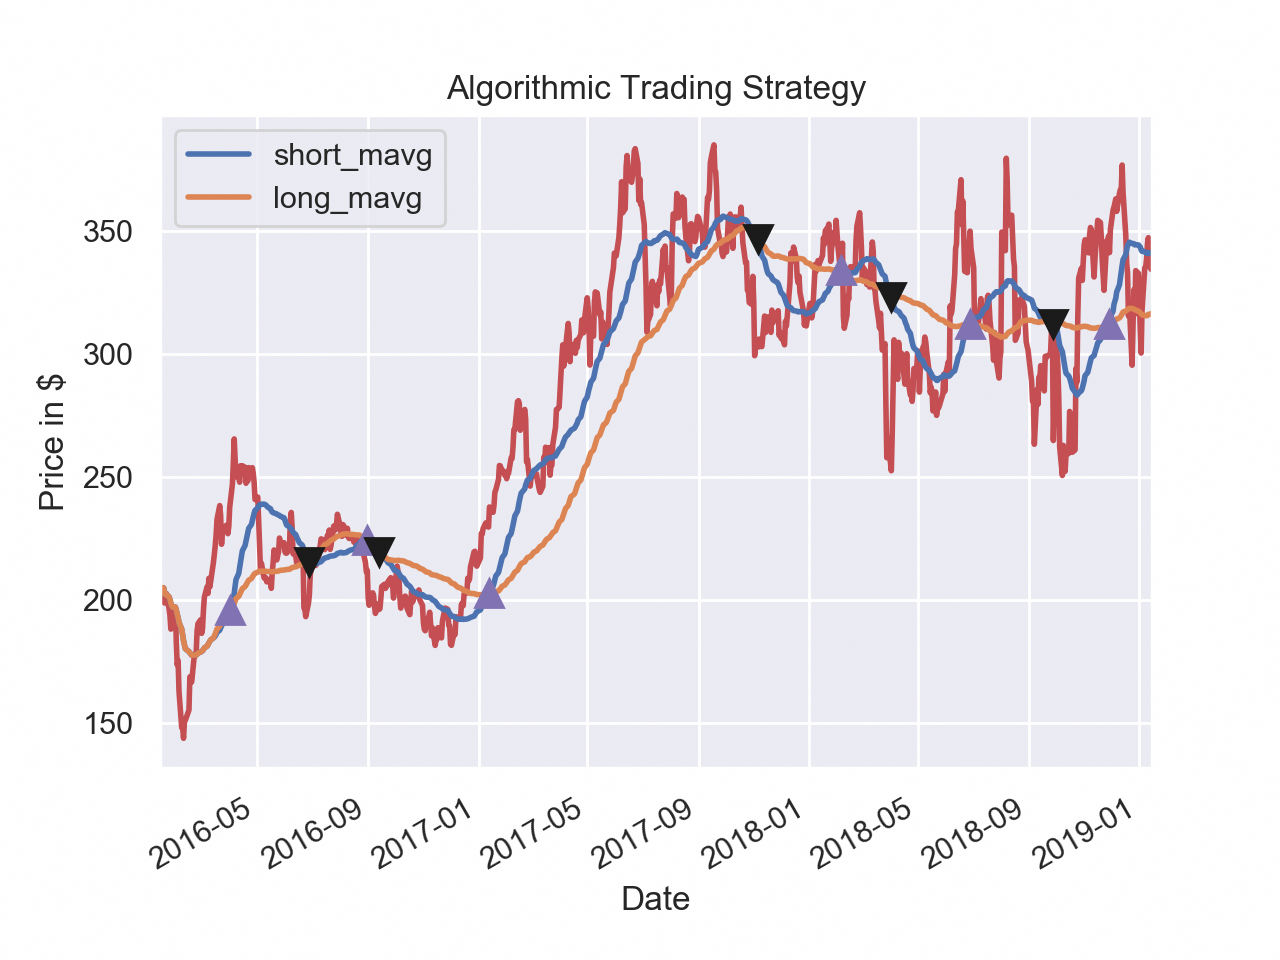

Sharpe Ratio:  -0.429
Compound Annual Growth Rate:  0.189


In [7]:
#### Trading Strategy ####
def trading_strategy():
    # Initialize the short and long windows
    short_window = 40
    long_window = 100
    # Initialize the `signals` DataFrame with the `signal` column
    signals = pd.DataFrame(index=tesla.index)
    signals['signal'] = 0.0
    # Create short simple moving average over the short window
    signals['short_mavg'] = tesla['Close'].rolling(window=short_window, min_periods=1, center=False).mean()
    # Create long simple moving average over the long window
    signals['long_mavg'] = tesla['Close'].rolling(window=long_window, min_periods=1, center=False).mean()
    # Create signals
    signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                                > signals['long_mavg'][short_window:], 1.0, 0.0)   
    # Generate trading orders
    signals['positions'] = signals['signal'].diff()
    
    return signals


#### Backtesting ####
def backtesting(signals):
    # Set the initial capital
    initial_capital= float(100000.0)
    # Create a DataFrame `positions`
    positions = pd.DataFrame(index=signals.index).fillna(0.0)
    # Buy a 100 shares
    positions['TSLA'] = 100*signals['signal']   
    # Initialize the portfolio with value owned   
    portfolio = positions.multiply(tesla['Adj Close'], axis=0)
    # Store the difference in shares owned 
    pos_diff = positions.diff()
    # Add `holdings` to portfolio
    portfolio['holdings'] = (positions.multiply(tesla['Adj Close'], axis=0)).sum(axis=1)
    # Add `cash` to portfolio
    portfolio['cash'] = initial_capital - (pos_diff.multiply(tesla['Adj Close'], axis=0)).sum(axis=1).cumsum()   
    # Add `total` to portfolio
    portfolio['total'] = portfolio['cash'] + portfolio['holdings']
    # Add `returns` to portfolio
    portfolio['returns'] = portfolio['total'].pct_change()
    
    return portfolio


#### Sharpe Ratio ####
def sharpe_ratio(portfolio):
    # Isolate the returns of your strategy
    returns = portfolio['returns']
    # annualized Sharpe ratio
    sharpe_ratio = np.sqrt(252) * (returns.mean() / returns.std())
    
    return sharpe_ratio

#### Compound Annual Growth Rate ####
def cagr():
    # Get the number of days in `tesla`
    days = (tesla.index[-1] - tesla.index[0]).days
    # Calculate the CAGR 
    cagr = ((((tesla['Adj Close'][-1]) / tesla['Adj Close'][1])) ** (365.0/days)) - 1
    
    return cagr

#### Extract Buy/Sell signals ####
def extract_signals(signals, indicator):
    locs = signals.loc[signals.positions == indicator].index
    prices = signals.short_mavg[signals.positions == indicator]
    
    return locs, signals

#### Sentiment Score ####
def sentiment_score(positives, negatives):
    total = postives + negatives
    cumulative = postives - negatives
    return cumulative / total
    
    
signals = trading_strategy()
portfolio = backtesting(signals)
sharpe_ratio = sharpe_ratio(portfolio)
cagr = cagr()

sns.set()

# Initialize the plot figure
fig = plt.figure(1)
# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,  ylabel='Price in $')
# Plot the closing price
tesla['Close'].plot(ax=ax1, color='r', lw=2.)
# Plot the short and long moving averages
signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)
# Plot the buy signals
ax1.plot(signals.loc[signals.positions == 1.0].index, 
         signals.short_mavg[signals.positions == 1.0],
         '^', markersize=10, color='m')         
# Plot the sell signals
ax1.plot(signals.loc[signals.positions == -1.0].index, 
         signals.short_mavg[signals.positions == -1.0],
         'v', markersize=10, color='k') 
plt.title("Algorithmic Trading Strategy")
# Show the plot
plt.show()

print("Sharpe Ratio: ", round(sharpe_ratio, 3))
print("Compound Annual Growth Rate: ", round(cagr, 3))